In [1]:
from zoish.feature_selectors.optunashap import OptunaShapFeatureSelector
import xgboost
from optuna.pruners import HyperbandPruner
from optuna.samplers._tpe.sampler import TPESampler
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)
import lightgbm
import matplotlib.pyplot as plt
import optuna


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[I 2022-08-10 00:25:38,349] A new study created in memory with name: no-name-dedcfd20-6a71-4118-b042-43df5c6682a4


<Figure size 432x288 with 0 Axes>

# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [3]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [4]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [6]:
optuna_classification_lgb = OptunaShapFeatureSelector(
        # general argument setting        
        verbose=1,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=4,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=lightgbm.LGBMClassifier(),
        estimator_params={
        "max_depth": [4, 9],
        "reg_alpha": [0, 1],

        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=False,
        save_shap_summary_plot=True,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## optuna params
        test_size=0.33,
        with_stratified = False,
        performance_metric = 'f1',
        # optuna study init params
        study = optuna.create_study(
            storage = None,
            sampler = TPESampler(),
            pruner= HyperbandPruner(),
            study_name  = None,
            direction = "maximize",
            load_if_exists = False,
            directions  = None,
            ),
        study_optimize_objective_n_trials=10, 

)

[I 2022-08-10 00:25:39,281] A new study created in memory with name: no-name-23390a8f-bb63-4c41-b1fd-6ea955d06010
root - INFO - Setting value for logging_basicConfig
root - INFO - Setting value for verbose
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - LGBMClassifier()
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Setting value for estimator_params
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline

In [7]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('optuna_classification_lgb', optuna_classification_lgb),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

root - INFO - Getting value for estimator
root - INFO - Getting value for performance metric
root - INFO - Getting value for estimator_params
root - INFO - Getting value for verbose
root - INFO - Getting value for test_size
root - INFO - Getting value for random_state
root - INFO - Getting value for study
root - INFO - Getting value for study optimize objective
root - INFO - Getting value for study_optimize_objective_n_trials
root - INFO - Getting value for study_optimize_objective_timeout
root - INFO - Getting value for study_optimize_n_jobs
root - INFO - Getting value for study_optimize_catch
root - INFO - Getting value for study_optimize_callbacks
root - INFO - Getting value for study_optimize_gc_after_trial
root - INFO - Getting value for study_optimize_show_progress_bar
root - INFO - Getting value for with_stratified
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
A column-vector y w

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[I 2022-08-10 00:25:41,395] Trial 2 finished with value: 0.6854891661195011 and parameters: {'max_depth': 4, 'reg_alpha': 0.5852406239394166}. Best is trial 2 with value: 0.6854891661195011.


[43]	valid_0's binary_logloss: 0.294698[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[58]	valid_0's binary_logloss: 0.291351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's binary_logloss: 0.291506
[60]	valid_0's binary_logloss: 0.29178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's binary_logloss: 0.286761
[36]	valid_0's binary_logloss: 0.29399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's binary_logloss: 0.286542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	valid_0's binary_logloss: 0.295103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's binary_logloss: 0.290984
[60]	valid_0's binary_logloss: 0.29138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[52

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[67]	valid_0's binary_logloss: 0.289346
[49]	valid_0's binary_logloss: 0.29187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's binary_logloss: 0.289181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	valid_0's binary_logloss: 0.289815
[68]	valid_0's binary_logloss: 0.289151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's binary_logloss: 0.28878
[50]	valid_0's binary_logloss: 0.291224
[67]	valid_0's binary_logloss: 0.288705
[1]	valid_0's binary_logloss: 0.505047
[41]	valid_0's binary_logloss: 0.291909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's binary_logloss: 0.291723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's binary_logloss: 0.289117
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2022-08-10 00:25:42,348] Trial 7 finished with value: 0.6923575129533678 and parameters: {'max_depth': 5, 'reg_alpha': 0.9937317406078037}. Best is trial 7 with value: 0.6923575129533678.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
[I 2022-08-10 00:25:42,390] Trial 1 finished with value: 0.6977950713359274 and parameters: {'max_depth': 5, 'reg_alpha': 0.47181539761699565}. Best is trial 1 with value: 0.6977950713359274.
[I 2022-08-10 00:25:42,400] Trial 5 finished with value: 0.690861

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's binary_logloss: 0.283655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's binary_logloss: 0.284511
[73]	valid_0's binary_logloss: 0.283648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's binary_logloss: 0.28403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's binary_logloss: 0.282149
[59]	valid_0's binary_logloss: 0.285292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's binary_logloss: 0.283679
[19]	valid_0's binary_logloss: 0.319061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's binary_logloss: 0.284105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's binary_logloss: 0.283486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2022-08-10 00:25:42,665] Trial 4 finished with value: 0.6915584415584415 and parameters: {'max_depth': 5, 'reg_alpha': 0.5675547360606876}. Best is trial 1 with value: 0.6977950713359274.


[31]	valid_0's binary_logloss: 0.301324
[72]	valid_0's binary_logloss: 0.283817
[71]	valid_0's binary_logloss: 0.283704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's binary_logloss: 0.281068
[11]	valid_0's binary_logloss: 0.357463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's binary_logloss: 0.300369
[72]	valid_0's binary_logloss: 0.283571
[73]	valid_0's binary_logloss: 0.28389
[90]	valid_0's binary_logloss: 0.281067
[12]	valid_0's binary_logloss: 0.351471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's binary_logloss: 0.283275
[33]	valid_0's binary_logloss: 0.299524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's binary_logloss: 0.281114
[74]	valid_0's binary_logloss: 0.283809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	valid_0's binary_logloss: 0.345785
[34]	valid_0's binary_logl

[I 2022-08-10 00:25:42,865] Trial 3 finished with value: 0.6968033580884727 and parameters: {'max_depth': 6, 'reg_alpha': 0.5837105279562862}. Best is trial 1 with value: 0.6977950713359274.


[82]	valid_0's binary_logloss: 0.282711
[83]	valid_0's binary_logloss: 0.283169
[23]	valid_0's binary_logloss: 0.314477
[44]	valid_0's binary_logloss: 0.291377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	valid_0's binary_logloss: 0.291016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's binary_logloss: 0.312953
[83]	valid_0's binary_logloss: 0.282602
[84]	valid_0's binary_logloss: 0.283295
[46]	valid_0's binary_logloss: 0.290333
[25]	valid_0's binary_logloss: 0.311654
[84]	valid_0's binary_logloss: 0.282713
[85]	valid_0's binary_logloss: 0.283554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	valid_0's binary_logloss: 0.310079
[47]	valid_0's binary_logloss: 0.28997
[85]	valid_0's binary_logloss: 0.282586
[86]	valid_0's binary_logloss: 0.283428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's binary_logloss: 0.308789
[48]	valid_0's binary

[I 2022-08-10 00:25:43,129] Trial 6 finished with value: 0.6970663265306123 and parameters: {'max_depth': 9, 'reg_alpha': 0.07035297471077195}. Best is trial 1 with value: 0.6977950713359274.
[I 2022-08-10 00:25:43,169] Trial 0 finished with value: 0.6966794380587484 and parameters: {'max_depth': 9, 'reg_alpha': 0.3828901619898748}. Best is trial 1 with value: 0.6977950713359274.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's binary_logloss: 0.282578
[41]	valid_0's binary_logloss: 0.2958
[62]	valid_0's binary_logloss: 0.284836
[98]	valid_0's binary_logloss: 0.282126
[42]	valid_0's binary_logloss: 0.295402
[100]	valid_0's binary_logloss: 0.282419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's binary_logloss: 0.284597
[99]	valid_0's binary_logloss: 0.282196
[43]	valid_0's binary_logloss: 0.29479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's binary_logloss: 0.284181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	valid_0's binary_logloss: 0.29428
[100]	valid_0's binary_logloss: 0.281986
[65]	valid_0's binary_logloss: 0.284053
[45]	valid_0's binary_logloss: 0.293917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's binary_logloss: 0.283846
[46]	valid_0's binary_loglo

[I 2022-08-10 00:25:43,437] Trial 8 finished with value: 0.6929032258064517 and parameters: {'max_depth': 7, 'reg_alpha': 0.2823085119882378}. Best is trial 1 with value: 0.6977950713359274.


[58]	valid_0's binary_logloss: 0.288306
[77]	valid_0's binary_logloss: 0.282149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's binary_logloss: 0.287545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's binary_logloss: 0.281985
[60]	valid_0's binary_logloss: 0.287137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[61]	valid_0's binary_logloss: 0.286675
[79]	valid_0's binary_logloss: 0.28215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's binary_logloss: 0.286179
[80]	valid_0's binary_logloss: 0.281877
[63]	valid_0's binary_logloss: 0.285982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's binary_logloss: 0.285421
[81]	valid_0's binary_logloss: 0.281912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's binary_logloss: 0.285316
[LightGBM] [Warning] No further

[I 2022-08-10 00:25:43,627] Trial 9 finished with value: 0.6940226171243943 and parameters: {'max_depth': 6, 'reg_alpha': 0.9169170472120671}. Best is trial 1 with value: 0.6977950713359274.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's binary_logloss: 0.280516
[96]	valid_0's binary_logloss: 0.280514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's binary_logloss: 0.280502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's binary_logloss: 0.280486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's binary_logloss: 0.28049
[100]	valid_0's binary_logloss: 0.280539
{'max_depth': 5, 'reg_alpha': 0.47181539761699565}


root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


LGBMClassifier


root - INFO - Getting value for plot shap summary
root - INFO - Getting value for save_shap_summary_plot
root - INFO - Getting value for n_features


.values =
array([[-1.16449916e+00, -1.95577565e-03,  4.69444536e-03, ...,
        -2.64080529e-02,  4.56079141e-02, -4.69625856e-04],
       [-3.37409336e-01, -1.97308775e-02,  1.65215331e-02, ...,
        -2.09488815e-02, -4.34599963e-02, -2.85777248e-04],
       [ 4.88608425e-01,  1.48346506e-02, -3.41440824e-01, ...,
        -2.31335066e-02,  3.65187375e-02, -4.12026876e-04],
       ...,
       [ 6.90863588e-01,  4.17631656e-03, -2.42531266e-01, ...,
        -6.01564979e-02,  5.17380226e-01, -2.40163093e-03],
       [-5.82017407e-01, -4.68048765e-03, -3.71500513e-01, ...,
        -5.91829819e-02,  6.03840794e-01,  5.98642441e-03],
       [-1.72292083e+00, -1.23336949e-02, -4.16060440e-02, ...,
        -1.86285723e-02, -4.29268620e-02, -1.28446280e-03]])

.base_values =
array([[-2.19785794],
       [-2.19785794],
       [-2.19785794],
       ...,
       [-2.19785794],
       [-2.19785794],
       [-2.19785794]])

.data =
array([[    24,      1, 228649, ...,      0,     38,      1],
 

root - INFO - Getting value for path_to_save_plot
root - INFO - Getting value for shap_fig
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


                 0         1
0              age  0.710389
1        workclass  0.050971
2           fnlwgt  0.076554
3        education   0.01444
4    education-num  0.461486
5   marital-status  0.834451
6       occupation  0.295358
7     relationship   0.42168
8             race  0.042904
9              sex  0.105144
10    capital-gain   0.47956
11    capital-loss  0.113397
12  hours-per-week  0.356663
13  native-country  0.014413
       column_name shap_importance
0              age        0.710389
1        workclass        0.050971
2           fnlwgt        0.076554
3        education         0.01444
4    education-num        0.461486
5   marital-status        0.834451
6       occupation        0.295358
7     relationship         0.42168
8             race        0.042904
9              sex        0.105144
10    capital-gain         0.47956
11    capital-loss        0.113397
12  hours-per-week        0.356663
13  native-country        0.014413
       column_name shap_importance
5   m

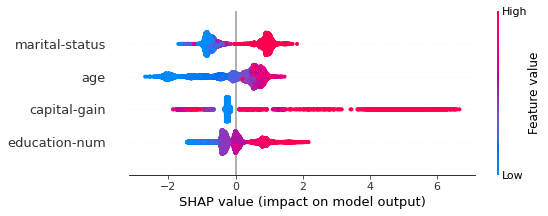

In [8]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [9]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.6111595466434175
Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      8158
           1       0.70      0.54      0.61      2588

    accuracy                           0.83     10746
   macro avg       0.78      0.73      0.75     10746
weighted avg       0.83      0.83      0.83     10746

Confusion matrix : 
[[7560  598]
 [1186 1402]]
